In [ ]:
#Madjid Tehrani
#Cybersec-DMS (DMS GmbH)
#https://www.cybersec-dms.com/
# Copyright © 2023, DMS GmbH. All rights reserved. Permission is hereby granted, free of charge, to any person obtaining a copy of this
# software and associated documentation files (the "Software"), for academic research purposes, subject to the following conditions:
# the above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

In [ ]:
!pip install qiskit
!pip install -U azure-quantum
!pip install -U azure-quantum[qiskit]
!pip install qiskit-machine-learning
!pip install pylatexenc
!pip install scikit-multiflow

In [2]:
import qiskit.tools.jupyter
%qiskit_version_table

In [ ]:
# Establish a connection to the Azure Quantum workspace
# This configuration setup is required exclusively for those intending to execute the algorithm on a particular backend.
# Microsoft Quantum provides substantial research credits, accessible via: https://learn.microsoft.com/en-us/azure/quantum/credits-faq
# To leverage these resources, an Azure account must be set up, followed by the acquisition of the aforementioned credits.
# Subsequent to these steps, you'll be able to input your resource_id and location to establish a connection to the quantum devices.
# For the ease of academic review, this experiment has been made accessible on an AER simulator.

from qiskit import QuantumCircuit
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from azure.quantum.qiskit import AzureQuantumProvider

provider = AzureQuantumProvider(
            resource_id = "",
            location = "")

print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

In [1]:
# To facilitate academic review, the associated dataset has been made freely accessible via the data container provided below.
!wget https://dgadata.blob.core.windows.net/dga/BotnetDgaDataset_5000_newMethod.csv

--2023-06-24 12:32:36--  https://dgadata.blob.core.windows.net/dga/BotnetDgaDataset_5000_newMethod.csv
Resolving dgadata.blob.core.windows.net (dgadata.blob.core.windows.net)... 20.60.2.68
Connecting to dgadata.blob.core.windows.net (dgadata.blob.core.windows.net)|20.60.2.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379327 (370K) [text/csv]
Saving to: ‘BotnetDgaDataset_5000_newMethod.csv.1’

BotnetDgaDataset_50 100%[===================>] 370.44K  2.39MB/s    in 0.2s    

2023-06-24 12:32:36 (2.39 MB/s) - ‘BotnetDgaDataset_5000_newMethod.csv.1’ saved [379327/379327]



Accuracy for increment 1: 65.73426573426573%
Accuracy for increment 2: 68.93106893106892%
Accuracy for increment 3: 71.22877122877122%
Accuracy for increment 4: 70.42957042957043%
time= 3000 5.676642417000039


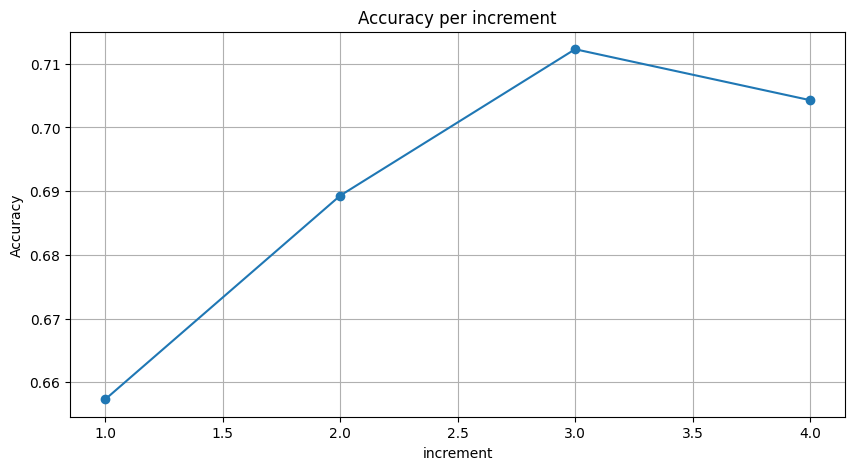

In [9]:
# This block of code implements the Hoeffding Tree Classifier (HTC) in Python for incremental learning.
# The HTC is a versatile decision tree classifier commonly employed in data stream mining, which offers high accuracy and efficiency.
# We used https://link.springer.com/chapter/10.1007/978-3-642-23544-3_36 and this implementation is our version of that algorithm:

# Our Python implementation aims to provide an interactive process to understand this form of incremental learning.
# For an alternative, one might consider using existing libraries that already include this implementation.
# An example is the 'skmultiflow' library, which offers a range of tools for multi-output/multi-label and stream data mining.
# The HoeffdingTreeClassifier within this library can be accessed via the following link: https://scikit-multiflow.readthedocs.io/en/stable/api/generated/skmultiflow.trees.HoeffdingTreeClassifier.html
# This section of the code utilizes the Hoeffding Tree Classifier (HTC) algorithm to reproduce the results displayed in Table 6 of our paper.
# The aim is to validate the accuracy and performance of the HTC algorithm as indicated in the original research.

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

start = time.perf_counter()


class HoeffdingTreeClassifier:
    def __init__(self, n_features, n_classes, delta=0.01, tie_threshold=0.05):
        self.n_features = n_features
        self.n_classes = n_classes
        self.delta = delta
        self.tie_threshold = tie_threshold

        # Initialize the root node of the tree
        self.root = TreeNode()

    def predict(self, X):
        """Predict the class labels for the input instances X."""
        y_pred = []
        for x in X:
            node = self.root
            while not node.is_leaf():
                if node.split_attr is None:
                    break
                feature_val = x[node.split_attr]
                if feature_val not in node.children:
                    break
                node = node.children[feature_val]
            y_pred.append(node.get_majority_class())  # Use the majority class label of the leaf node
        return y_pred


    def partial_fit(self, X, y):
        """Update the tree with new training instances X and their corresponding class labels y."""
        n_samples = X.shape[0]
        for i in range(n_samples):
            x = X[i]
            label = y[i]
            self._update_statistics(x, label)
            self._attempt_split(self.root)

    def _update_statistics(self, x, label):
        """Update the statistics of the tree nodes based on the input instance and its class label."""
        node = self.root
        node.total_samples += 1

        # Initialize the class count for the label if not present
        if label not in node.class_counts:
            node.class_counts[label] = 0

        node.class_counts[label] += 1

        while node.is_split():
            attr = node.split_attr
            attr_val = x[attr]
            if attr_val not in node.children:
                node.children[attr_val] = TreeNode()
            node = node.children[attr_val]
            node.total_samples += 1

            # Initialize the class count for the label if not present
            if label not in node.class_counts:
                node.class_counts[label] = 0

            node.class_counts[label] += 1



    def _attempt_split(self, node):
        """Attempt to split the given node based on the Hoeffding bound gain."""
        if not node.is_split():
            if node.total_samples >= 2:
                node.compute_error_rate()

            if node.total_samples >= 2 and node.error_rate > self._hoeffding_bound(node.total_samples):
                self._split_node(node)
        else:
            for child in node.children.values():
                self._attempt_split(child)

    def _split_node(self, node):
        """Split the given node by selecting the best attribute based on the Hoeffding bound gain."""
        node.compute_best_splitting_attribute(self.n_classes, self.n_features)

        for attr_val in node.children:
            child = node.children[attr_val]
            if child.total_samples >= 2:
                child.compute_error_rate()

            if child.total_samples < 2 or child.error_rate <= self._hoeffding_bound(child.total_samples):
                continue

            # Create a new leaf node for the child
            leaf_node = TreeNode()
            leaf_node.label = child.get_majority_class()
            node.children[attr_val] = leaf_node

    def _hoeffding_bound(self, n):
        """Compute the Hoeffding bound for the given number of samples n."""
        return np.sqrt((self.n_classes * np.log(1 / self.delta)) / (2 * n))


class TreeNode:
    def __init__(self):
        self.split_attr = None
        self.children = {}
        self.class_counts = {}
        self.total_samples = 0
        self.error_rate = 0.0
        self.label = None

    def is_leaf(self):
        """Check if the node is a leaf (no children)."""
        return not self.children

    def is_split(self):
        """Check if the node is split (has children)."""
        return self.split_attr is not None

    def compute_error_rate(self):
        """Compute the error rate of the node based on the class distribution."""
        total_samples = float(self.total_samples)
        error_sum = total_samples - max(self.class_counts.values())
        self.error_rate = error_sum / total_samples

    def compute_best_splitting_attribute(self, n_classes, n_features):
        """Compute the best attribute to split on based on the Hoeffding bound gain."""
        best_gain = -np.inf
        best_attr = None

        for attr in range(n_features):
            class_counts_per_value = {}
            total_samples_per_value = {}

            for attr_val, child in self.children.items():
                class_counts_per_value[attr_val] = child.class_counts.get(attr_val, np.zeros(n_classes))
                total_samples_per_value[attr_val] = child.total_samples

            split_gain = self._compute_hoeffding_bound_gain(class_counts_per_value, total_samples_per_value,
                                                            n_classes, self.total_samples)

            if split_gain > best_gain:
                best_gain = split_gain
                best_attr = attr

        if best_attr is not None:
            self.split_attr = best_attr

    def _compute_hoeffding_bound_gain(self, class_counts_per_value, total_samples_per_value, n_classes, total_samples):
        """Compute the Hoeffding bound gain for the given attribute values and their class counts."""
        gain = 0.0

        for attr_val in class_counts_per_value:
            class_counts = class_counts_per_value[attr_val]
            total_samples_val = total_samples_per_value[attr_val]
            error_val = total_samples_val - np.max(class_counts)
            error_rate_val = error_val / total_samples_val

            gain -= total_samples_val / total_samples * self._hoeffding_bound(error_rate_val)

        return gain

    def _hoeffding_bound(self, error_rate):
        """Compute the Hoeffding bound for the given error rate."""
        R = 1  # Range of the target variable for binary classification
        return np.sqrt((R ** 2 * np.log(1 / self.delta)) / (2 * error_rate))

    def get_majority_class(self):
        """Get the majority class label based on the class distribution."""
        max_count = -np.inf
        majority_class = None

        for class_label, count in self.class_counts.items():
            if count > max_count:
                max_count = count
                majority_class = class_label

        return majority_class



# Loading your data
data = pd.read_csv('BotnetDgaDataset_5000_newMethod.csv')
X = data.drop(['Result'], axis=1)
y = data['Result']

# Normalizing the features
X = preprocessing.StandardScaler().fit_transform(X)

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert pandas Series to numpy array
y_train = y_train.values
y_test = y_test.values

# Create a Hoeffding Tree object
ht = HoeffdingTreeClassifier(n_features=X.shape[1], n_classes=np.unique(y_train).shape[0])

# List to store accuracy for each round
accuracy_list = []

incrementsize = 1000
# Train the model incrementally
for i in range(0, len(X_train), incrementsize): # train on incrementes of incrementsize instances
    ht.partial_fit(X_train[i:i+incrementsize], y_train[i:i+incrementsize])

    # Predicting the test set results
    y_pred = ht.predict(X_test)

    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for increment {i//incrementsize + 1}: {accuracy*100}%")

    accuracy_list.append(accuracy)
end = time.perf_counter()
print("time=",i, end-start)
# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(X_train)//incrementsize + 1), accuracy_list, marker='o')
plt.title('Accuracy per increment')
plt.xlabel('increment')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


Accuracy for increment 1: 0.571
AUC for increment 1: 0.5113895216400911
F1-score for increment 1: 0.044543429844098
Accuracy for increment 2: 0.99
AUC for increment 2: 0.9886104783599089
F1-score for increment 2: 0.988479262672811
Accuracy for increment 3: 1.0
AUC for increment 3: 1.0
F1-score for increment 3: 1.0
Accuracy for increment 4: 1.0
AUC for increment 4: 1.0
F1-score for increment 4: 1.0
Accuracy for increment 5: 1.0
AUC for increment 5: 1.0
F1-score for increment 5: 1.0
Accuracy for increment 6: 1.0
AUC for increment 6: nan
F1-score for increment 6: 1.0


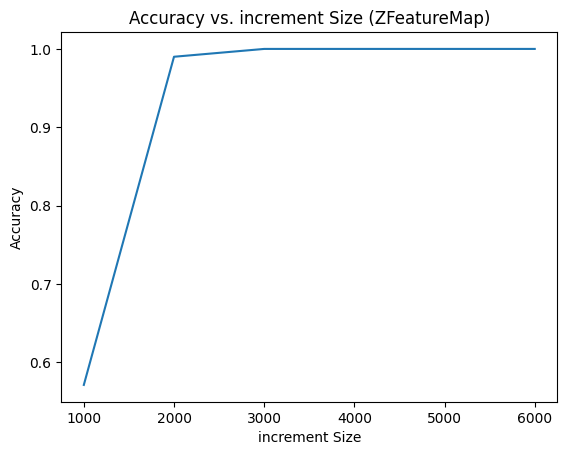

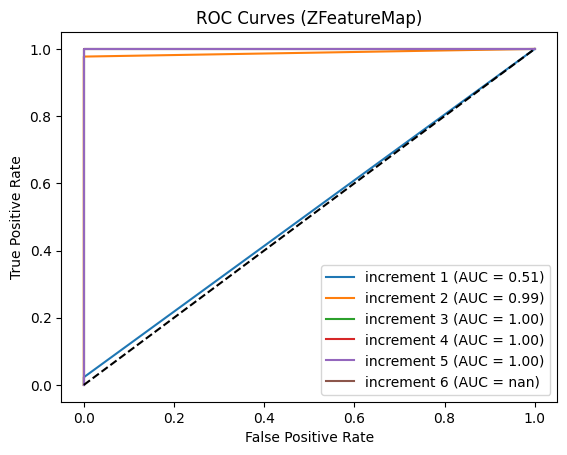

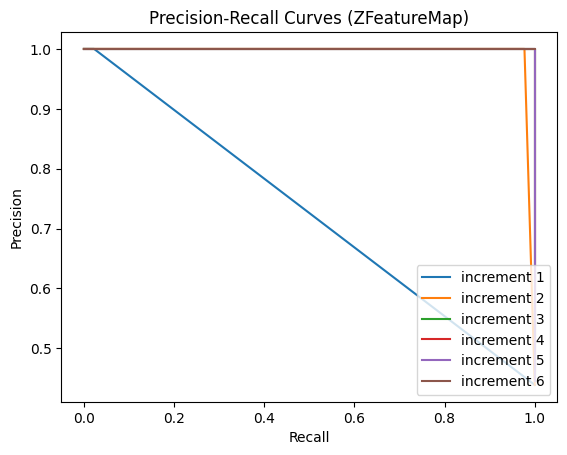

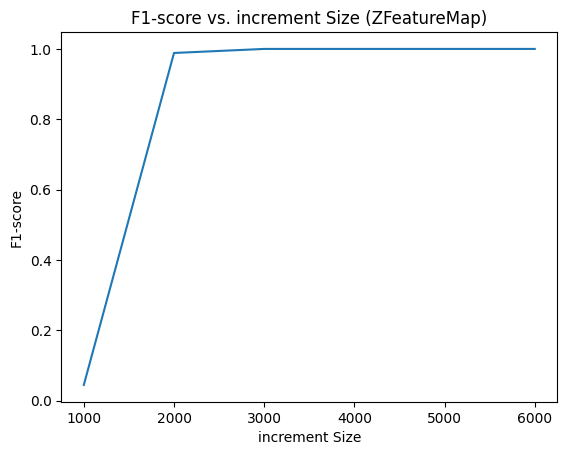

time of round= 1 420.0057445540001
Accuracy for increment 1: 0.571
AUC for increment 1: 0.5113895216400911
F1-score for increment 1: 0.044543429844098
Accuracy for increment 2: 0.99
AUC for increment 2: 0.9886104783599089
F1-score for increment 2: 0.988479262672811
Accuracy for increment 3: 1.0
AUC for increment 3: 1.0
F1-score for increment 3: 1.0
Accuracy for increment 4: 1.0
AUC for increment 4: 1.0
F1-score for increment 4: 1.0
Accuracy for increment 5: 1.0
AUC for increment 5: 1.0
F1-score for increment 5: 1.0
Accuracy for increment 6: 1.0
AUC for increment 6: nan
F1-score for increment 6: 1.0


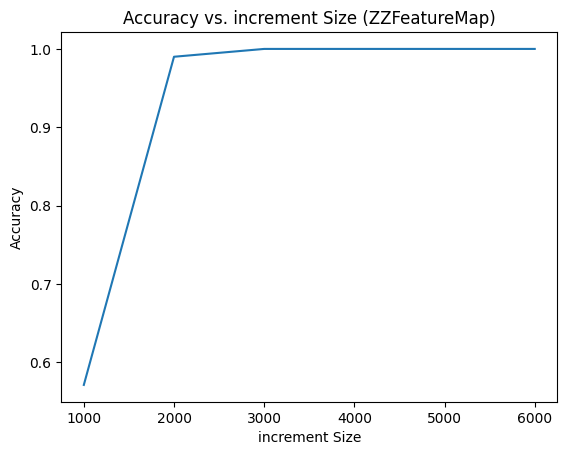

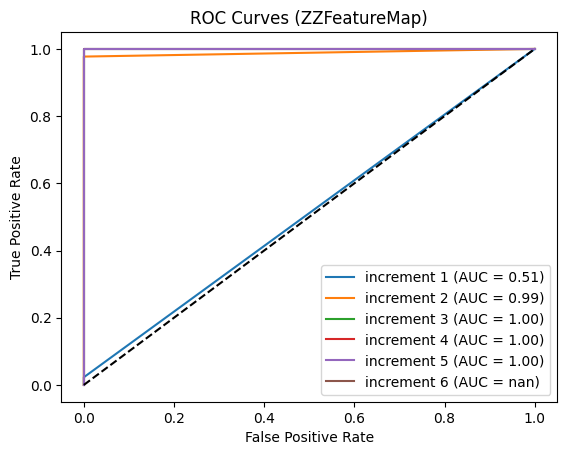

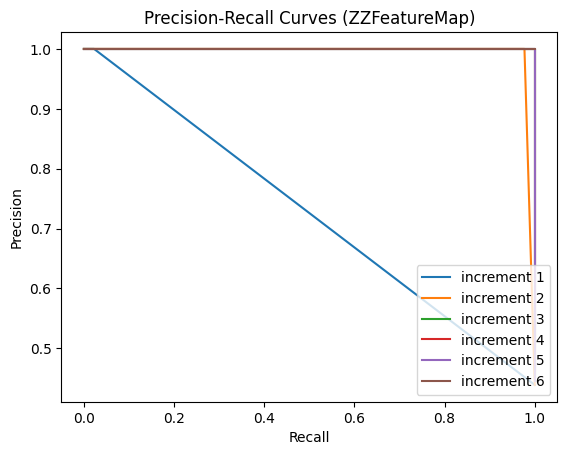

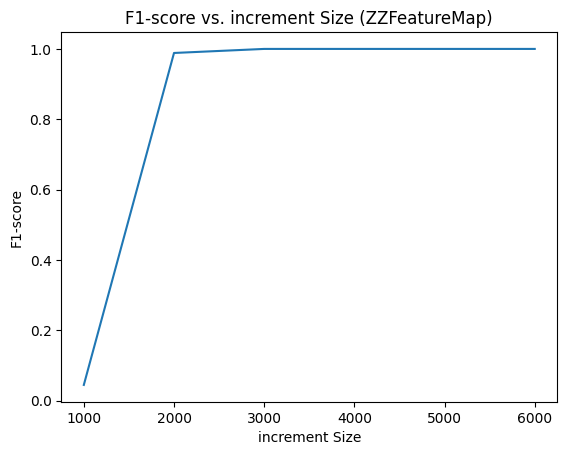

time of round= 2 462.1605534129999
Accuracy for increment 1: 0.571
AUC for increment 1: 0.5113895216400911
F1-score for increment 1: 0.044543429844098
Accuracy for increment 2: 0.99
AUC for increment 2: 0.9886104783599089
F1-score for increment 2: 0.988479262672811
Accuracy for increment 3: 1.0
AUC for increment 3: 1.0
F1-score for increment 3: 1.0
Accuracy for increment 4: 1.0
AUC for increment 4: 1.0
F1-score for increment 4: 1.0
Accuracy for increment 5: 1.0
AUC for increment 5: 1.0
F1-score for increment 5: 1.0
Accuracy for increment 6: 1.0
AUC for increment 6: nan
F1-score for increment 6: 1.0


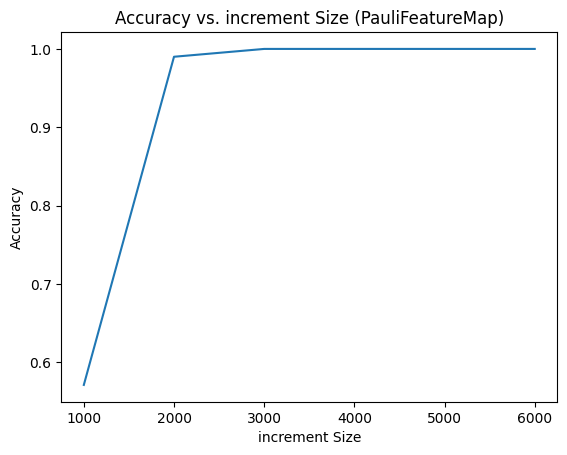

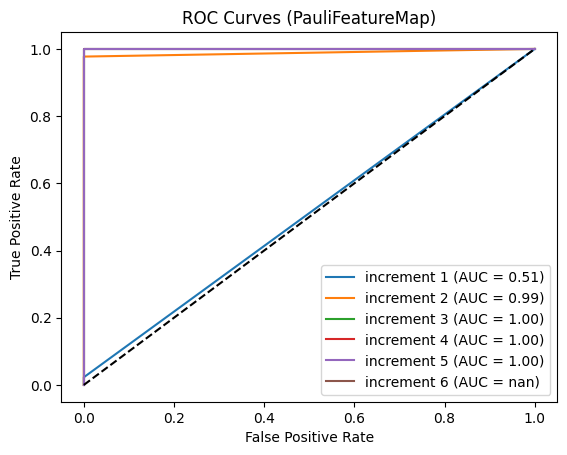

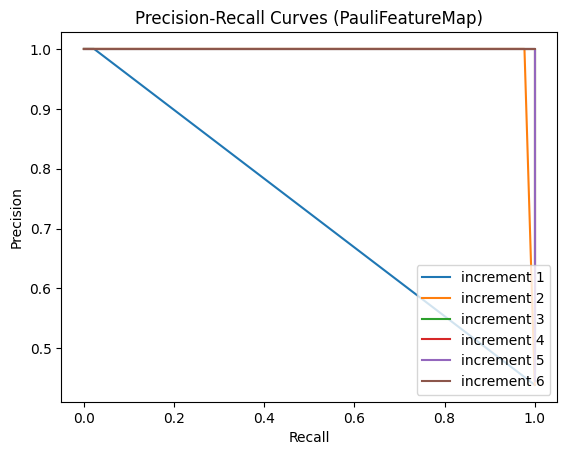

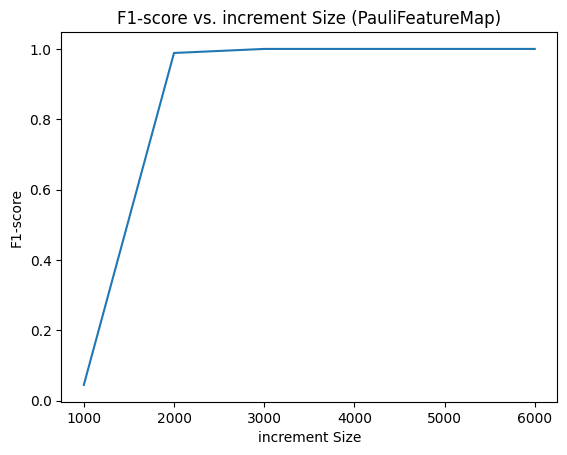

time of round= 3 482.44364448000033


In [10]:
#Quantum enhanced HTC
from qiskit import execute, Aer
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, StatePreparation
import warnings
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, auc
from sklearn import preprocessing

warnings.filterwarnings("ignore")

class HoeffdingTreeClassifier:
    def __init__(self, n_features, n_classes, delta=0.01, tie_threshold=0.05):
        self.n_features = n_features
        self.n_classes = n_classes
        self.delta = delta
        self.tie_threshold = tie_threshold

        # Initialize the root node of the tree
        self.root = TreeNode(self.delta)

    def predict(self, X):
        """Predict the class labels for the input instances X."""
        y_pred = []
        for x in X:
            node = self.root
            while not node.is_leaf():
                if node.split_attr is None:
                    break
                feature_val = str(x[node.split_attr])  # Convert feature_val to a string
                if feature_val not in node.children:
                    break
                node = node.children[feature_val]
            y_pred.append(node.get_majority_class())  # Use the majority class label of the leaf node
        return y_pred

    def partial_fit(self, X, y):
        """Update the tree with new training instances X and their corresponding class labels y."""
        n_samples = X.shape[0]
        for i in range(n_samples):
            x = X[i]
            label = y[i]
            self._update_statistics(x, label)
            self._attempt_split(self.root)


    def _update_statistics(self, x, label):
        """Update the statistics of the tree nodes based on the input instance and its class label."""
        node = self.root
        node.total_samples += 1

        # Initialize the class count for the label if not present
        if label not in node.class_counts:
            node.class_counts[label] = 0

        node.class_counts[label] += 1

        while node.is_split():
            attr = node.split_attr
            attr_val = str(x[attr])  # Convert attr_val to a string

            if attr_val not in node.children:
                node.children[attr_val] = TreeNode(self.delta)
            node = node.children[attr_val]
            node.total_samples += 1

            # Initialize the class count for the label if not present
            if label not in node.class_counts:
                node.class_counts[label] = 0

            node.class_counts[label] += 1


    def _attempt_split(self, node):
        """Attempt to split the given node based on the Hoeffding bound gain."""
        if not node.is_split():
            if node.total_samples >= 2:
                node.compute_error_rate()

            if node.total_samples >= 2 and node.error_rate > self._hoeffding_bound(node.total_samples):
                self._split_node(node)
        else:
            for child in node.children.values():
                self._attempt_split(child)

    def _split_node(self, node):
        """Split the given node by selecting the best attribute based on the Hoeffding bound gain."""
        node.compute_best_splitting_attribute(self.n_classes, self.n_features)

        for attr_val in node.children:
            child = node.children[attr_val]
            if child.total_samples >= 2:
                child.compute_error_rate()

            if child.total_samples < 2 or child.error_rate <= self._hoeffding_bound(child.total_samples):
                continue

            # Create a new leaf node for the child
            leaf_node = TreeNode(self.delta)
            leaf_node.label = child.get_majority_class()
            node.children[attr_val] = leaf_node

    def _hoeffding_bound(self, n):
        """Compute the Hoeffding bound for the given number of samples n."""
        return np.sqrt((self.n_classes * np.log(1 / self.delta)) / (2 * n))


class TreeNode:
    def __init__(self, delta):
        self.split_attr = None
        self.children = {}
        self.class_counts = {}
        self.total_samples = 0
        self.error_rate = 0.0
        self.label = None
        self.delta = delta

    def is_leaf(self):
        """Check if the node is a leaf (no children)."""
        return not self.children

    def is_split(self):
        """Check if the node is split (has children)."""
        return self.split_attr is not None

    def compute_error_rate(self):
        """Compute the error rate of the node based on the class distribution."""
        total_samples = float(self.total_samples)
        error_sum = total_samples - max(self.class_counts.values())
        self.error_rate = error_sum / total_samples

    def compute_best_splitting_attribute(self, n_classes, n_features):
        """Compute the best attribute to split on based on the Hoeffding bound gain."""
        best_gain = -np.inf
        best_attr = None

        for attr in range(n_features):
            class_counts_per_value = {}
            total_samples_per_value = {}

            for attr_val, child in self.children.items():
                class_counts_per_value[attr_val] = child.class_counts.get(attr_val, np.zeros(n_classes))
                total_samples_per_value[attr_val] = child.total_samples

            split_gain = self._compute_hoeffding_bound_gain(class_counts_per_value, total_samples_per_value,
                                                            n_classes, self.total_samples)

            if split_gain > best_gain:
                best_gain = split_gain
                best_attr = attr

        if best_attr is not None:
            self.split_attr = best_attr

    def _compute_hoeffding_bound_gain(self, class_counts_per_value, total_samples_per_value, n_classes, total_samples):
        """Compute the Hoeffding bound gain for the given attribute values and their class counts."""
        gain = 0.0

        for attr_val in class_counts_per_value:
            class_counts = class_counts_per_value[attr_val]
            total_samples_val = total_samples_per_value[attr_val]
            error_val = total_samples_val - np.max(class_counts)
            error_rate_val = error_val / total_samples_val

            gain -= total_samples_val / total_samples * self._hoeffding_bound(error_rate_val)

        return gain

    def _hoeffding_bound(self, error_rate):
        """Compute the Hoeffding bound for the given error rate."""
        R = 1  # Range of the target variable for binary classification
        return np.sqrt((R ** 2 * np.log(1 / self.delta)) / (2 * error_rate))

    def get_majority_class(self):
        """Get the majority class label based on the class distribution."""
        max_count = -np.inf
        majority_class = None

        for class_label, count in self.class_counts.items():
            if count > max_count:
                max_count = count
                majority_class = class_label

        return majority_class



def compute_L2_norm(parameters):
    """ Compute the L2 norm of a list of parameters """
    return np.linalg.norm(parameters)


def generate_quantum_features(features, feature_map, shots=1024, filename='quantum_features.csv'):
    quantum_features = []
    quantum_parameters = []

    for feature in features:
        quantum_feature = feature_map.bind_parameters(dict(zip(feature_map.parameters, feature)))
        quantum_features.append(quantum_feature)
        quantum_parameters.append(feature)  # Here we keep the parameters used

    return np.array(quantum_features), quantum_parameters



def run_hoeffding_tree(data_encoding_fn):
    # Load the dataset
    df = pd.read_csv('BotnetDgaDataset_5000_newMethod.csv')

    # Extract the features and labels
    features = df.iloc[:, :-1].values
    labels = df.iloc[:, -1].values

    # Normalize the features
    scaler = preprocessing.StandardScaler()
    features = scaler.fit_transform(features)

    # Map the features to a quantum feature space using the provided data encoding function
    feature_map = data_encoding_fn(feature_dimension=features.shape[1])
    quantum_features, quantum_parameters = generate_quantum_features(features, feature_map)
    # Data-encoding like ZFeatureMap makes parameters,
    # as an example,
    # It takes our first row of features and it will make parameters like ZFeatureMap(0.1916,-0.48517,-0.21314,-0.40599,-0.46622,-1.0084,-0.25332)
    # This means for the frist given data point x = (x1, x2, ..., xn):
    #    U(x) = Π_{i=1}^{n} U_{Z_i}(x_i) Π_{j=1}^{n} Π_{k > j}^{n} U_{ZZ_{jk}}(x_j, x_k)
    # Here, U_{Z_i}(x_i) represents a rotation around the Z axis for qubit i for an angle of x_i and
    #    U_{ZZ_{jk}}(x_j, x_k) represents a rotation in the ZZ plane for qubits j and k for an angle of x_j * x_k.
    # In other word U_{Z_i}(x_i) = [[e^{-ix_i/2}, 0], [0, e^{ix_i/2}]] and U_{ZZ_{jk}}(x_j, x_k) = exp(-i * x_j * x_k / 2 * Z_j ⊗ Z_k)
    # so that U(x) is like the below for that specific ZFeaturemap
    # U(x) = U_Z(0.1916) U_Z(-0.48517) U_Z(-0.21314) U_Z(-0.40599) U_Z(-0.46622) U_Z(-1.0084) U_Z(-0.25332)
    #       * U_ZZ(0.1916, -0.48517) U_ZZ(0.1916, -0.21314) U_ZZ(0.1916, -0.40599) U_ZZ(0.1916, -0.46622) U_ZZ(0.1916, -1.0084) U_ZZ(0.1916, -0.25332)
    #       * U_ZZ(-0.48517, -0.21314) U_ZZ(-0.48517, -0.40599) U_ZZ(-0.48517, -0.46622) U_ZZ(-0.48517, -1.0084) U_ZZ(-0.48517, -0.25332)
    #       * U_ZZ(-0.21314, -0.40599) U_ZZ(-0.21314, -0.46622) U_ZZ(-0.21314, -1.0084) U_ZZ(-0.21314, -0.25332)
    #       * U_ZZ(-0.40599, -0.46622) U_ZZ(-0.40599, -1.0084) U_ZZ(-0.40599, -0.25332)
    #       * U_ZZ(-0.46622, -1.0084) U_ZZ(-0.46622, -0.25332)
    #       * U_ZZ(-1.0084, -0.25332)
    # Where:
    #       U_Z(θ) = [[e^{-iθ/2}, 0],    [0, e^{iθ/2}]]
    # And:
    #       U_ZZ(x_j, x_k) = exp(-i * x_j * x_k / 2 * Z_j ⊗ Z_k)
    # therefore we must make a simple independent metric for classification of the results that works for our problem
    # we measured qubits and we learned after measurement we have the below result for the above ZFeatureMap
    # {'1010100':	1,	'1110110':	1,	'1100010':	2,	'1000100':	1,	'1010000':	2,	'1100110':	1,	'1000110':	1,	'1110000':	1}
    # The key '1010100', for instance, represents the quantum state |1010100>. amd numbers are showing the number that it was in this position.
    # Mathematically, |1010100> is represented as the tensor product: |1010100> = |1> ⊗ |0> ⊗ |1> ⊗ |0> ⊗ |1> ⊗ |0> ⊗ |0>.
    # The trivial independent metric is to measure the distance of the our parameter vector from the origin in parameter space:L2_norm(θ) = sqrt( Σ_i |θ_i|^2 )
    L2_norms = [compute_L2_norm(params) for params in quantum_parameters]
    new_features = np.array(L2_norms).reshape(-1, 1)  # Transform to column vector
    new_data = np.concatenate((new_features, labels.reshape(-1, 1)), axis=1)

    # Initialize the HoeffdingTreeClassifier
    n_features = quantum_features.shape[1]
    n_classes = len(np.unique(labels))
    htc = HoeffdingTreeClassifier(n_features, n_classes)

    # Store accuracy, increment number, and additional metrics
    accuracies = []
    incrementes = []
    roc_auc_values = []
    precisions = []
    recalls = []
    f1_scores = []
    # Store fpr, tpr, and additional metrics for each increment
    fpr_values = []
    tpr_values = []
    # Set the desired test percentage
    test_percentage = 0.2

    # Calculate the increment size based on the test percentage
    increment_size = int(len(quantum_features) * test_percentage)

    # Iterate over the data in incrementes
    for i in range(0, len(new_data), increment_size):
        # Split the increment into training and testing sets
        X_train = np.concatenate((new_data[:i, :-1], new_data[i+increment_size:, :-1]))
        y_train = np.concatenate((new_data[:i, -1], new_data[i+increment_size:, -1]))
        X_test = new_data[i:i+increment_size, :-1]
        y_test = new_data[i:i+increment_size, -1]

        # Train the HoeffdingTreeClassifier with the increment data
        htc.partial_fit(X_train, y_train)

        # Calculate accuracy on the test data
        test_predictions = htc.predict(X_test)
        test_accuracy = np.mean(test_predictions == y_test)

        # Calculate additional performance metrics

        fpr, tpr, _ = roc_curve(y_test, test_predictions)

        # Store fpr and tpr for the current increment
        fpr_values.append(fpr)
        tpr_values.append(tpr)

        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(y_test, test_predictions)
        f1 = f1_score(y_test, test_predictions)

        # Store accuracy, increment number, and additional metrics
        accuracies.append(test_accuracy)
        incrementes.append(i+increment_size)
        roc_auc_values.append(roc_auc)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        # Print or store the accuracy and additional metrics as desired
        print(f"Accuracy for increment {i//increment_size + 1}: {test_accuracy}")
        print(f"AUC for increment {i//increment_size + 1}: {roc_auc}")
        print(f"F1-score for increment {i//increment_size + 1}: {f1}")

    # Get the name of the data encoding function
    encoding_name = data_encoding_fn.__name__

    # Plot accuracy vs. increment
    plt.plot(incrementes, accuracies)
    plt.xlabel('increment Size')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs. increment Size ({encoding_name})')
    plt.show()

    # Plot ROC curves
    plt.figure()
    for i in range(len(fpr_values)):
        if i < len(roc_auc_values):  # Check if roc_auc_values has enough values
            roc_auc = roc_auc_values[i]
            label = f'increment {i+1} (AUC = {roc_auc:.2f})'
        else:
            label = f'increment {i+1}'
        plt.plot(fpr_values[i], tpr_values[i], label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves ({encoding_name})')
    plt.legend(loc='lower right')
    plt.show()

    # Plot precision-recall curves
    plt.figure()
    for i in range(len(incrementes)):
        plt.plot(recalls[i], precisions[i], label=f'increment {i+1}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves ({encoding_name})')
    plt.legend(loc='lower right')
    plt.show()

    # Plot F1-score vs. increment
    plt.plot(incrementes, f1_scores)
    plt.xlabel('increment Size')
    plt.ylabel('F1-score')
    plt.title(f'F1-score vs. increment Size ({encoding_name})')
    plt.show()



# Define a list of data encoding functions
data_encoding_functions = [ZFeatureMap, ZZFeatureMap, PauliFeatureMap]
start=start = time.perf_counter()
round=0
# Run the Hoeffding Tree algorithm for each data encoding function
for data_encoding_fn in data_encoding_functions:
    start=start = time.perf_counter()
    run_hoeffding_tree(data_encoding_fn)
    end = time.perf_counter()
    round=round+1
    print("time of round=",round, end-start)